In [0]:
!pip install q numpy==1.17

In [0]:
import re

import os
from os import listdir
from os.path import isfile, join

import torch
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np

from PIL import Image

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj" -O openlogo.tar && rm -rf /tmp/cookies.txt
!tar -xvf openlogo.tar

images_folder = "openlogo/JPEGImages"
annotations_folder = "openlogo/Annotations"
train_query_file = "openlogo/ImageSets/Main/train_test/train_all.txt"
test_query_file = "openlogo/ImageSets/Main/train_test/test_all.txt"

In [0]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [0]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
image_pattern = re.compile(r'^(?P<key>\w+)\.jpg$')
annotation_pattern = re.compile(r'^(?P<key>\w+)\.xml$')

class LogoDetectionDataset(Dataset):
  
  def __init__(self, image_folder, annotation_folder, query_file, transform=None):
    self.image_folder = image_folder
    self.annotation_folder = annotation_folder
    self.transform = transform
    self.image_names = self.__get_file_names__(image_folder, image_pattern)
    self.annotation_names = self.__get_file_names__(annotation_folder, annotation_pattern)

    self.keys = sorted(list(set(self.image_names.keys()) & set(self.annotation_names.keys())))
    with open(query_file) as file:
      file_content = file.read()
      self.keys = list(filter(lambda key: key in file_content, self.keys))
  
  def __len__(self):
    return len(self.keys)

  def __getitem__(self, index): 
    key = self.keys[index]

    image_name = self.image_names[key]
    annotation_name = self.annotation_names[key]

    image_path = os.path.join(self.image_folder, image_name)
    annotation_path = os.path.join(self.annotation_folder, annotation_name)

    img = Image.open(image_path).convert('RGB')
    target = self.__get_target__(annotation_path, index)

    if self.transform:
      img, target = self.transform(img, target)

    return img, target

  def __get_target__(self, annotation_path, index):
    target = {}
    boxes = []
    root = ET.parse(annotation_path).getroot()
    for bndbox in root.findall('object/bndbox'):
      xmin = int(bndbox[0].text)
      ymin = int(bndbox[1].text)
      xmax = int(bndbox[2].text)
      ymax = int(bndbox[3].text)
      boxes.append((xmin, ymin, xmax, ymax))

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    num_objs = len(boxes)
    labels = torch.ones((num_objs), dtype=torch.int64)
    img_id = torch.tensor([index])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = img_id
    target['area'] = area
    target['iscrowd'] = iscrowd
    return target

  def __get_file_names__(self, folder, file_name_pattern):
    file_names = {}
    for f in listdir(folder):
      match = file_name_pattern.match(f)
      if not match:
        continue
      
      num = match.group('key')
      if num == '':
        continue
      
      file_names[num] = f

    return file_names

In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms

tfs = transforms.Compose([
                          transforms.ToTensor(),                       
                       ])

num_classes = 2
batch_size = 4

dataset = LogoDetectionDataset(images_folder, annotations_folder, train_query_file, transform=tfs)
test_dataset = LogoDetectionDataset(images_folder, annotations_folder, test_query_file, transform=tfs)
orig_test_dataset = LogoDetectionDataset(images_folder, annotations_folder, test_query_file)

validation_size = .5

data_size = len(dataset)
test_data_size = len(test_dataset)

split_val = int(np.floor(validation_size * data_size))

indices = list(range(data_size))
test_indices = list(range(test_data_size))
np.random.shuffle(indices)
np.random.shuffle(test_indices)
val_indices, train_indices = indices[:split_val], indices[split_val:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         sampler=val_sampler, collate_fn=utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          sampler=test_sampler, collate_fn=utils.collate_fn)

In [0]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [0]:
model = torch.load("drive/My Drive/save/save-complete")
model.to(device)

In [0]:
last_saved_epoch = 0
num_epochs = 5

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  torch.save(model, "drive/My Drive/save/save-" + str(last_saved_epoch + epoch))
  evaluate(model, val_loader, device=device)

torch.save(model, "drive/My Drive/save/save-complete")

In [0]:
import random

num_epochs = 3
lerning_rates = [0.01 + random.random() * 0.1, 0.001 + random.random() * 0.01, 0.0001 + random.random() * 0.001 ]
weight_decaies = [0.01 + random.random() * 0.1, 0.001 + random.random() * 0.01, 0.0001 + random.random() * 0.001 ]

for weight_dec in weight_decaies:
  for lerning_rate in lerning_rates:
    print("LR: %f, WD: %f" % (lerning_rate, weight_dec))
    for epoch in range(num_epochs):
      model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
      in_features = model.roi_heads.box_predictor.cls_score.in_features
      model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
      model.to(device)
    
      params = [p for p in model.parameters() if p.requires_grad]
      optimizer = torch.optim.SGD(params, lr=lerning_rate, momentum=0.9, weight_decay=weight_dec)
    
      train_one_epoch(model, optimizer, train_loader, device, 0, print_freq=500)
    print("LR: %f, WD: %f" % (lerning_rate, weight_dec))
    evaluate(model, val_loader, device=device)

LR: 0.107973, WD: 0.013113
Epoch: [0]  [   0/2317]  eta: 1:52:42  lr: 0.000216  loss: 1.7706 (1.7706)  loss_classifier: 0.7135 (0.7135)  loss_box_reg: 0.0303 (0.0303)  loss_objectness: 0.9813 (0.9813)  loss_rpn_box_reg: 0.0454 (0.0454)  time: 2.9187  data: 0.1941  max mem: 5970


In [0]:
model = torch.load("drive/My Drive/save/save-complete")
evaluate(model, test_loader, device=device)

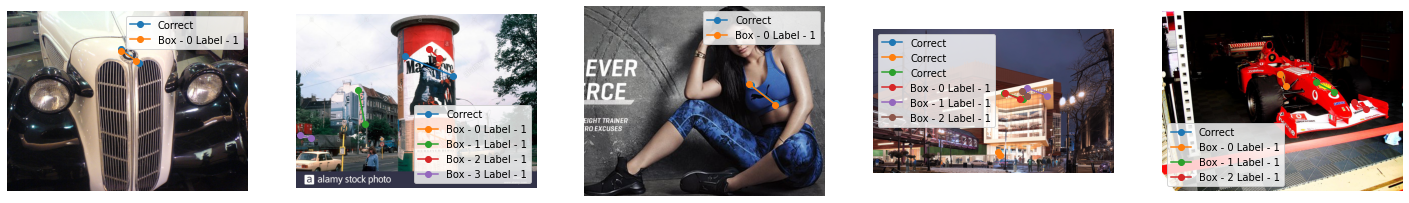

In [0]:
score_filter = 0.5

model_adam.eval()
count = 5
plt.figure(figsize=(count * 5,5))
for i_step, (images, targets) in enumerate(test_loader):
  if i_step == count:
    break
    
  test_image = list(image.to(device) for image in images)
  prediction = model_adam(test_image)[0]

  image_id = int(targets[0]['image_id'])
  image, target = orig_test_dataset[image_id]

  boxes = target['boxes']
  predict_boxes = prediction['boxes']
  predict_labels = prediction['labels']
  predict_scores = prediction['scores']

  plt.subplot(1, count, i_step + 1)
  plt.imshow(image)

  for box in boxes:
    x = [box[0], box[2]]
    y = [box[1], box[3]]
    plt.plot(x, y, marker = 'o', label='Correct')
  for i, box in enumerate(predict_boxes):
    if predict_scores[i] < score_filter:
      continue
    x = [box[0], box[2]]
    y = [box[1], box[3]]
    predict_label = int(predict_labels[i])
    view_label = 'Box - %d Label - %d' % (i, predict_label)
    plt.plot(x, y, marker = 'o', label=view_label)

  plt.grid(False)
  plt.axis('off')
  plt.legend()  